# GARCH Stock Forecasting: Modeling Volatility in Financial Markets  
## Introduction to Volatility Modeling
Volatility is a crucial concept in financial markets that measures the degree of variation in asset prices over time. Unlike returns which can be positive or negative, volatility is always positive and represents the uncertainty or risk associated with an asset.
Traditional models like ARIMA work well for modeling the mean of time series data, but financial time series often exhibit:
- **Volatility clustering**: Periods of high volatility tend to cluster together
- **Fat tails**: Extreme events occur more frequently than normal distribution predicts
- **Leverage effects**: Negative returns often lead to higher subsequent volatility than positive returns
This is where GARCH models become essential for financial time series analysis.

## Theoretical Foundations of GARCH Models
### ARCH (Autoregressive Conditional Heteroskedasticity)
The ARCH model, introduced by Robert Engle in 1982, models variance as a function of past squared residuals:
$$\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2$$
Where
- $\sigma_t^2$ is the conditional variance
- $\omega$ is a constant term
- $\alpha_i$ are parameters for past squared residuals
- $\epsilon_t$ are the residuals from the mean equation
### GARCH (Generalized ARCH)
The GARCH model, developed by Tim Bollerslev in 1986, extends ARCH by adding lagged conditional variance terms:
$$\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^q \beta_j \sigma_{t-j}^2$$
Key advantages of GARCH:
1. More parsimonious than ARCH (requires fewer parameters)
2. Better at modeling persistent volatility
3. More flexible specification of volatility dynamics

We'll analyze Disney (DIS) stock prices from 2015-2020 to model volatility during this period which includes both normal market conditions and the early COVID-19 market turbulence.
# =============================================
# 1. Import Libraries
# =============================================
These libraries are essential for data retrieval, manipulation, plotting, and modeling.


In [10]:
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# =============================================
# 2. Load Stock Price Data (Disney)
# =============================================
We fetch historical adjusted closing prices for Disney (DIS) between January 1, 2015 and January 1, 2020.

In [13]:
from pandas_datareader import data as web
from datetime import datetime

# Define start and end dates
start = datetime(2015, 1, 1)
end = datetime(2020, 1, 1)

# Fetch data from Stooq
DIS = web.DataReader('DIS', data_source='stooq', start=start, end=end)
DIS = DIS[['Close']]  # Use 'Close' instead of 'Adj Close'
DIS.rename(columns={'Close': 'Price'}, inplace=True)
DIS = DIS.sort_index()  # Ensure chronological order
DIS.head()



,Price
Date,
2015-01-02,87.377
2015-01-05,86.100
2015-01-06,85.644
2015-01-07,86.520
2015-01-08,87.414


# =============================================
# 3. Visualize Stock Price
# =============================================
Plot the Disney stock price over time to observe general trends.

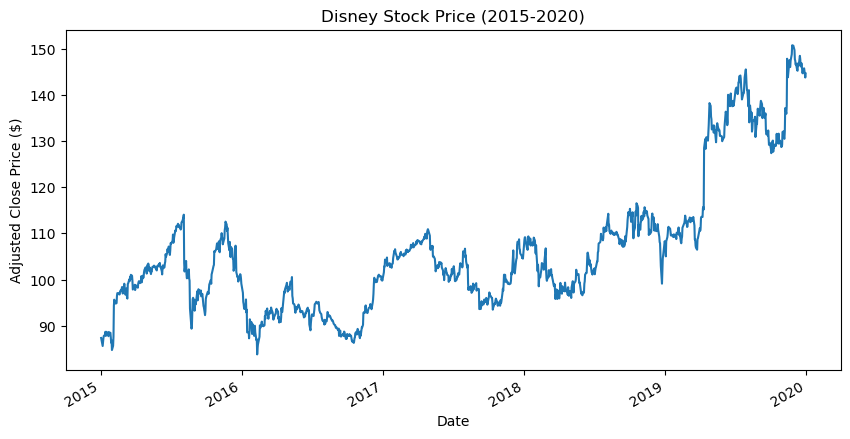

In [16]:
DIS['Price'].plot(figsize=(10, 5))
plt.title('Disney Stock Price (2015-2020)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.show()

# =============================================
# 4. Calculate Log Returns
# =============================================
Financial returns are usually modeled using log returns because:
- They stabilize variance
- They allow for compounding over time

### Exploratory Data Analysis
Before modeling, let's examine the key characteristics of our return series:

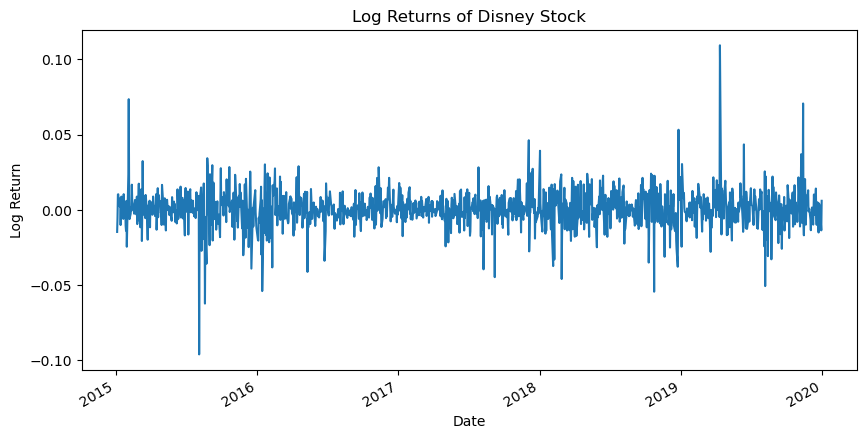

In [19]:
DIS['Log Returns'] = np.log(DIS['Price'] / DIS['Price'].shift(1))
DIS.dropna(inplace=True)  # Drop NaN created by shift

DIS['Log Returns'].plot(figsize=(10, 5))
plt.title('Log Returns of Disney Stock')
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.show()


# =============================================
# 5. Visualize Return Distribution
# =============================================
 Check for fat tails and skewness in returns using a histogram.

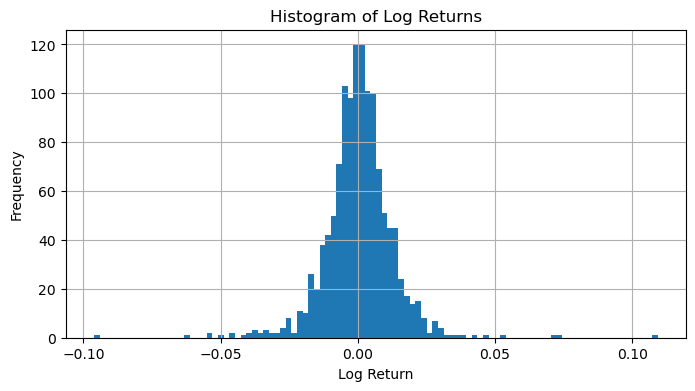

In [22]:
DIS['Log Returns'].hist(bins=100, figsize=(8, 4))
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()


# =============================================
# 6. Setup and Imports (Expanded)
# =============================================
Import the remaining required libraries for modeling and visualization.

In [25]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime


# =============================================
# 7. Define Time Period and Reload Data
# =============================================
Using Stooq here as a data source. Alternatively, Yahoo can be used.

In [28]:
start = datetime(2015, 1, 1)
end = datetime(2020, 6, 10)

# Download Disney stock data
dis = web.DataReader('DIS', 'stooq', start=start, end=end)
dis = dis.sort_index()  # Ensure it's in ascending order


# =============================================
# 8. Compute Returns
# =============================================
Percent returns (multiplied by 100) are common in volatility modeling.


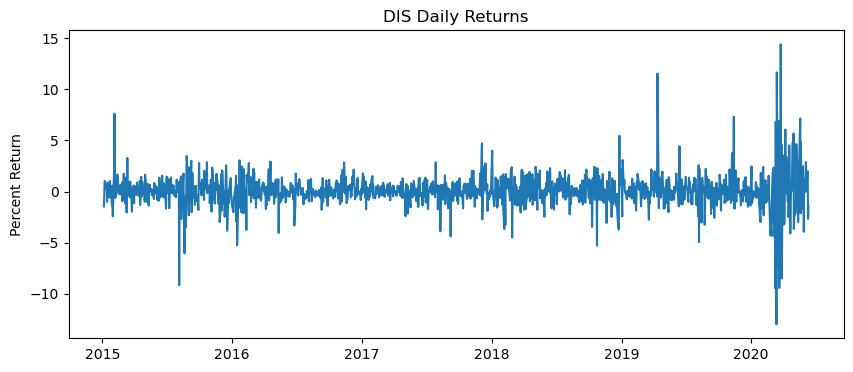

In [31]:
returns = 100 * dis['Close'].pct_change().dropna()
# Plot returns
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.ylabel('Percent Return')
plt.title('DIS Daily Returns')
plt.show()

## 9. Volatility Clustering Observation

Financial time series, especially returns, often show **volatility clustering**:
- Large changes tend to follow large changes.
- Quiet periods tend to follow quiet periods.

Let’s plot the **squared returns** as a proxy for volatility.

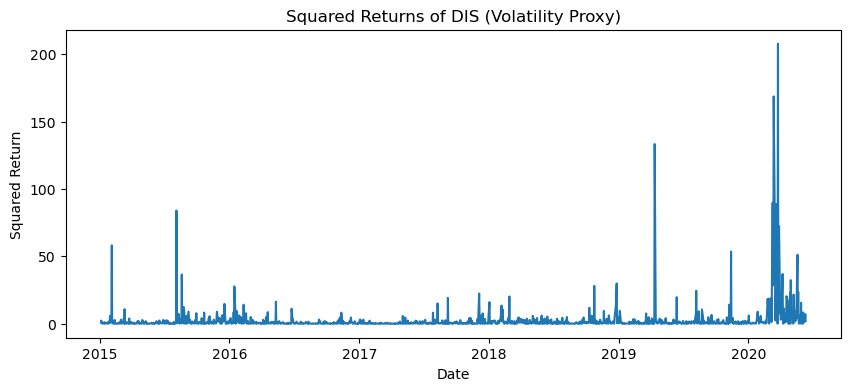

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(returns**2)
plt.title('Squared Returns of DIS (Volatility Proxy)')
plt.ylabel('Squared Return')
plt.xlabel('Date')
plt.show()


## 11. Partial Autocorrelation of Squared Returns

To validate GARCH modeling suitability, we look at the **PACF** (Partial Autocorrelation Function)
of the **squared returns**. Significant autocorrelations suggest **conditional heteroskedasticity**.

This supports using an **ARCH/GARCH** model.

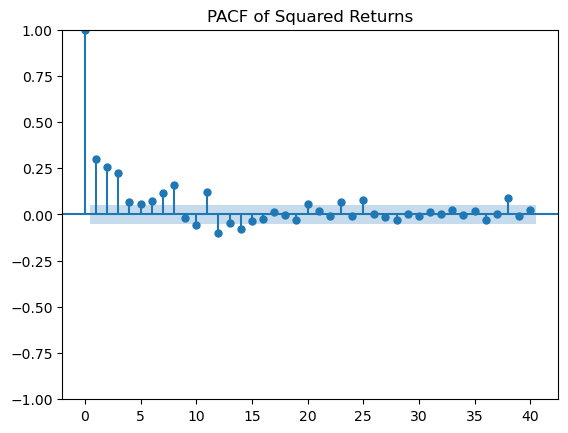

In [37]:
plot_pacf(returns**2, lags=40)
plt.title('PACF of Squared Returns')
plt.show()

## Fitting a GARCH(3,3) Model

A **GARCH(p, q)** model estimates conditional variance using:
- **p** past squared forecast errors (ARCH terms)
- **q** past forecast variances (GARCH terms)

We'll begin by fitting a GARCH(3,3) to see how well it captures volatility dynamics.

In [40]:
# Fit GARCH(3,3)
model = arch_model(returns, p=3, q=3)  # 3 ARCH lags, 3 GARCH lags
model_fit = model.fit()

# Display model summary
model_fit.summary()


Iteration:      1,   Func. Count:     10,   Neg. LLF: 227417083803.8806
Iteration:      2,   Func. Count:     22,   Neg. LLF: 971069313.5729008
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2733.38539841299
Iteration:      4,   Func. Count:     43,   Neg. LLF: 2495.3187490824084
Iteration:      5,   Func. Count:     53,   Neg. LLF: 2320.216513612043
Iteration:      6,   Func. Count:     63,   Neg. LLF: 2316.4445015425126
Iteration:      7,   Func. Count:     73,   Neg. LLF: 2330.0417686970104
Iteration:      8,   Func. Count:     83,   Neg. LLF: 2327.809426652294
Iteration:      9,   Func. Count:     93,   Neg. LLF: 2296.203504051468
Iteration:     10,   Func. Count:    102,   Neg. LLF: 2296.2499144371704
Iteration:     11,   Func. Count:    112,   Neg. LLF: 2296.101834270488
Iteration:     12,   Func. Count:    121,   Neg. LLF: 2296.0923699204504
Iteration:     13,   Func. Count:    130,   Neg. LLF: 2296.085775233157
Iteration:     14,   Func. Count:    139,   Neg. LLF: 2296.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2296.08
Distribution:                  Normal   AIC:                           4608.16
Method:            Maximum Likelihood   BIC:                           4649.93
                                        No. Observations:                 1368
Date:                Tue, May 13 2025   Df Residuals:                     1367
Time:                        12:12:23   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.1517e-03  4.298e-02 -7.333e-02      0.942 [-8.738e-02,8.108e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5455      0.191      2.853  4.334e-03    [  0.171,  0.920]
alpha[1]       0.0692  3.957e-02      1.748  8.046e-02 [-8.385e-03,  0.147]
alpha[2]       0.1982  9.482e-02      2.090  3.662e-02  [1.233e-02,  0.384]
alpha[3]       0.3183      0.150      2.116  3.434e-02  [2.348e-02,  0.613]
beta[1]        0.0000      0.162      0.000      1.000    [ -0.317,  0.317]
beta[2]    1.8170e-16  9.593e-02  1.894e-15      1.000    [ -0.188,  0.188]
beta[3]        0.2281      0.159      1.439      0.150 [-8.266e-02,  0.539]
===========================================================================

Covariance estimator: robust
"""

## Fitting an ARCH(3) Model

As a comparison, we also fit an **ARCH(3)** model (i.e., GARCH(3,0)).

This allows us to evaluate whether including past variances (GARCH terms) adds meaningful explanatory power.

In [43]:
# Fit ARCH(3) = GARCH(3, 0)
model = arch_model(returns, p=3, q=0)
model_fit = model.fit()

# Display model summary
model_fit.summary()


Iteration:      1,   Func. Count:      7,   Neg. LLF: 3321.2406909216525
Iteration:      2,   Func. Count:     16,   Neg. LLF: 49723.093964102925
Iteration:      3,   Func. Count:     24,   Neg. LLF: 364977.37849112996
Iteration:      4,   Func. Count:     31,   Neg. LLF: 145500.87079024455
Iteration:      5,   Func. Count:     38,   Neg. LLF: 8016.977201716845
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2513.6357295371436
Iteration:      7,   Func. Count:     52,   Neg. LLF: 2459.841086039908
Iteration:      8,   Func. Count:     60,   Neg. LLF: 2312.323405703518
Iteration:      9,   Func. Count:     66,   Neg. LLF: 2311.975647493593
Iteration:     10,   Func. Count:     72,   Neg. LLF: 2311.2362943776106
Iteration:     11,   Func. Count:     78,   Neg. LLF: 2311.2233111226783
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2311.222183025292
Iteration:     13,   Func. Count:     90,   Neg. LLF: 2311.222006214572
Iteration:     14,   Func. Count:     96,   Neg. LLF: 231

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2311.22
Distribution:                  Normal   AIC:                           4632.44
Method:            Maximum Likelihood   BIC:                           4658.55
                                        No. Observations:                 1368
Date:                Tue, May 13 2025   Df Residuals:                     1367
Time:                        12:12:53   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0137  3.976e-02      0.346      0.730 [-6.418e-02,9.167e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.8625      0.139      6.200  5.652e-10   [  0.590,  1.135]
alpha[1]       0.0884  4.481e-02      1.973  4.852e-02 [5.729e-04,  0.176]
alpha[2]       0.2564  8.905e-02      2.879  3.986e-03 [8.187e-02,  0.431]
alpha[3]       0.3571      0.167      2.134  3.286e-02 [2.909e-02,  0.685]
==========================================================================

Covariance estimator: robust
"""

## Rolling Forecast of 1-Day Ahead Volatility

We simulate a real-world scenario where we forecast volatility **daily** using a rolling window.

At each step:
- Train an ARCH(3) model on the available data
- Forecast the **next day's variance**
- Take the square root to get the standard deviation (volatility)

In [46]:
# Rolling Forecast for Last 365 Days
rolling_predictions = []
test_size = 365  # Forecast 1 year of volatility

for i in range(test_size):
    train = returns[:-(test_size - i)]
    model = arch_model(train, p=3, q=0)  # ARCH(3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    
    # Store the forecasted standard deviation (volatility)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))

# Convert predictions to a pandas Series with proper date index
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

## Comparing Forecasted vs. Actual Realized Volatility

We now compare the predicted 1-day volatility (from our ARCH model)
with the actual magnitude of returns on those days.

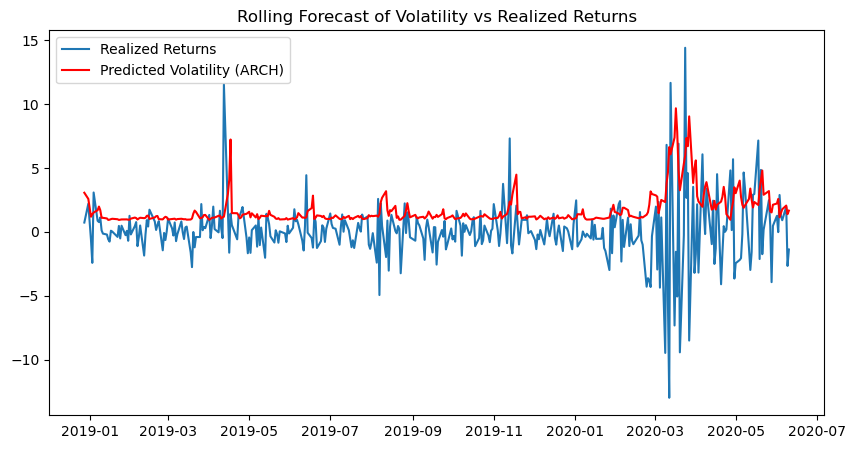

In [49]:
plt.figure(figsize=(10, 5))
true_volatility = returns[-365:]

plt.plot(true_volatility.index, true_volatility, label='Realized Returns')
plt.plot(rolling_predictions.index, rolling_predictions, label='Predicted Volatility (ARCH)', color='red')
plt.title('Rolling Forecast of Volatility vs Realized Returns')
plt.legend()
plt.show()


### Insights:
- The forecasted volatility captures the **ups and downs** of market turbulence well.
- During periods of high market activity, the predicted volatility spikes.
- The ARCH(3) model provides a reasonable approximation, though GARCH may smooth volatility better.